In [1]:
import warnings
import pandas as pd
import xgboost as xgb
from figures import *
from constants import *
from estimation import *
from pre_process import *
from independence import *
from functools import partial
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

warnings.simplefilter("ignore")

C:\Users\maaya\AppData\Roaming\Python\Python39\site-packages\matplotlib\projections\__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
features_df = features_engineer("data/NCDOT_BikePedCrash.csv", winter_filter=True)

In [3]:
features_df

,age_category,is_drunk_biker,severity,is_drunk_driver,y,x,speed_limit,is_wet,is_male,biker_location_Bike Lane / Paved Shoulder,...,road_surface_type_Coarse Asphalt,road_surface_type_Concrete,road_surface_type_Smooth Asphalt,weather_Clear,weather_Cloudy,weather_Rain,month_December,month_February,month_January,month_November
0,11,0,2,0,36.039490,-78.883896,30,0,1,0,...,0,0,1,1,0,0,0,0,1,0
1,20,0,1,0,35.751118,-78.782800,30,0,1,0,...,0,0,1,1,0,0,0,0,1,0
2,30,0,2,0,35.084732,-80.697820,20,0,1,0,...,0,0,1,0,1,0,0,0,1,0
3,30,0,1,0,35.684400,-80.479320,30,0,1,0,...,0,0,1,0,1,0,0,0,1,0
4,40,0,2,0,34.999428,-78.904450,30,0,1,0,...,1,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11251,40,0,1,0,35.077343,-78.958951,40,0,1,0,...,1,0,0,1,0,0,1,0,0,0
11253,60,0,3,0,35.534234,-77.025772,30,0,0,1,...,1,0,0,1,0,0,1,0,0,0
11255,30,0,2,0,35.118065,-77.077608,30,0,1,0,...,0,0,1,1,0,0,1,0,0,0
11256,50,0,0,0,35.718750,-78.624247,30,0,1,1,...,1,0,0,1,0,0,1,0,0,0


In [4]:
propensity_features = PROPENSITY_MODEL_WINTER_FEATURES
lr_propensity_df = calculate_propensity_score(features_df, LogisticRegression(max_iter=1000, random_state=42), features=propensity_features, scale=True)
gb_propensity_df = calculate_propensity_score(features_df, GradientBoostingClassifier(n_estimators=10, max_depth=5, min_samples_leaf=5, learning_rate=0.5, random_state=42), features=propensity_features, scale=True)
rf_propensity_df = calculate_propensity_score(features_df, RandomForestClassifier(n_estimators=10, max_depth=20, min_samples_leaf=3 ,class_weight='balanced', random_state=42), features=propensity_features, scale=True)
xgb_propensity_df = xgb_propensity_df = calculate_propensity_score(features_df, xgb.XGBClassifier(n_estimators=20, max_depth=20, learning_rate=0.2, subsample=0.6, random_state=42), features=propensity_features,scale=True)

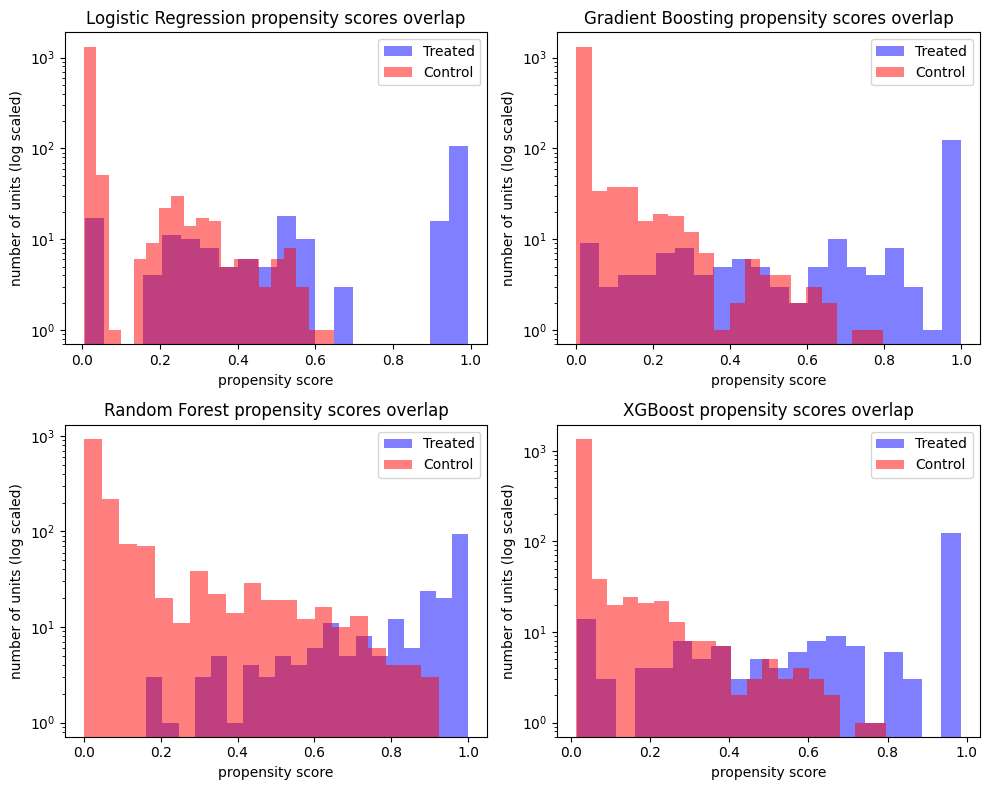

In [5]:
propensities_dict = {
                    'Logistic Regression': lr_propensity_df,
                     'Gradient Boosting': gb_propensity_df,
                     'Random Forest': rf_propensity_df,
                     'XGBoost': xgb_propensity_df
                    }
plot_propensity_models_hist(propensities_dict)

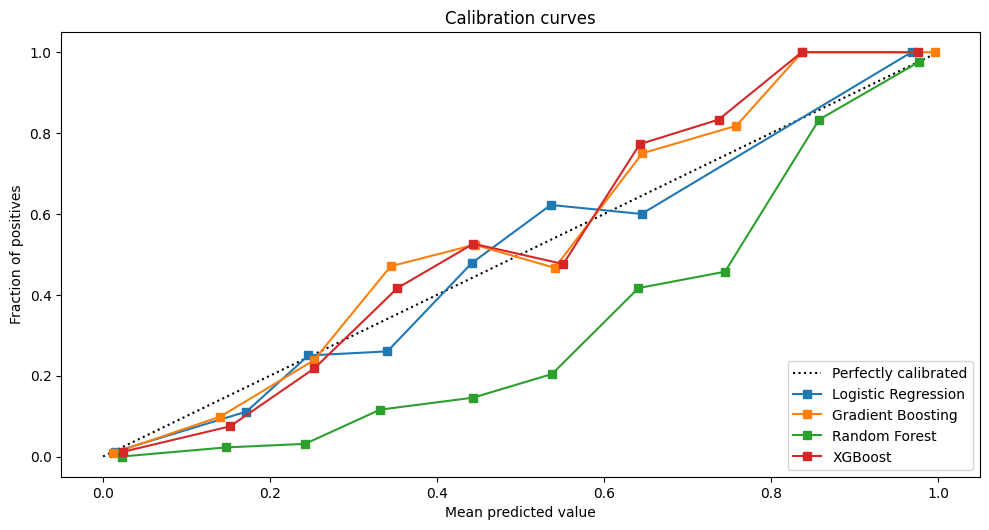

In [6]:
plot_calibration_curve(propensities_dict, features_df[T_BINARY])

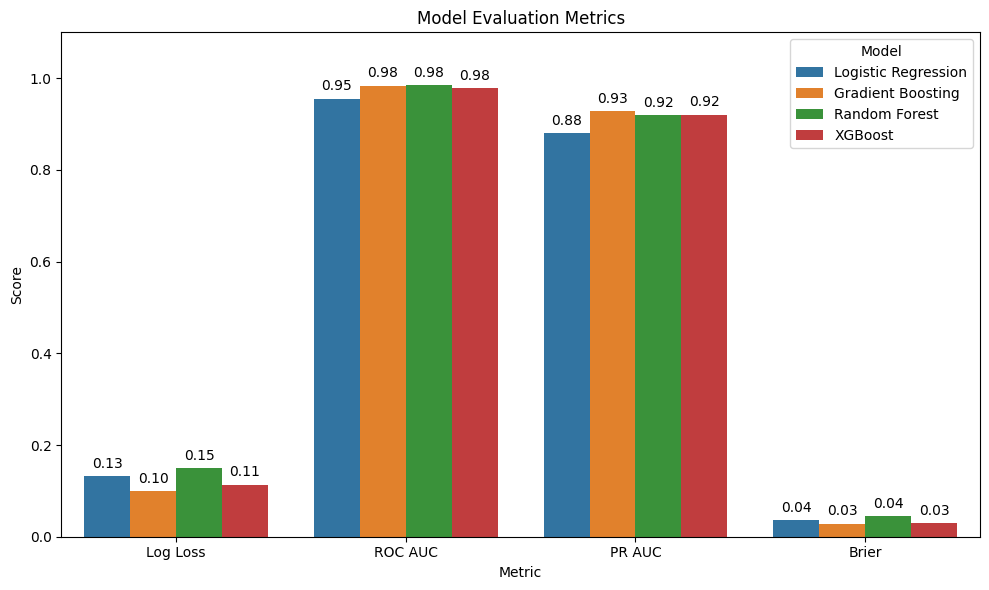

In [75]:
plot_evaluation_metrics(propensities_dict, features_df[T_BINARY])

In [18]:
naive_ate = estimate_naive_ate(features_df)

In [23]:
propensity_estimation_dfs = []
for model, propensity_df in propensities_dict.items():
    propensity_estimation_dfs.append(estimate_propensity_methods(propensity_df, model))

propensity_estimation_df = pd.concat(propensity_estimation_dfs, axis=0)
display(propensity_estimation_df)

,propensity_model,IPW,Matching
0,Logistic Regression,0.237913,-0.286150
0,Gradient Boosting,-0.550372,-0.223776
0,Random Forest,-1.317741,0.140275
0,XGBoost,-0.614287,-0.011129


is_wet
0    Axes(0.125,0.11;0.775x0.77)
1    Axes(0.125,0.11;0.775x0.77)
Name: propensity_score, dtype: object

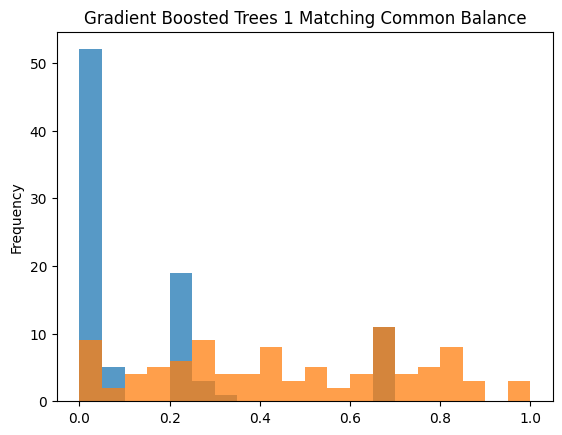

In [13]:
gb_propensity_df = gb_propensity_df.reset_index(drop=True)
matches = matching(label=gb_propensity_df[T_BINARY],
                      propensity=gb_propensity_df['propensity_score'],
                      calipher=0.1,
                      replace=True)

matches_df = matching_to_dataframe(match=matches,
                                    covariates=gb_propensity_df,
                                    remove_duplicates=False)
matches_df.groupby(T_BINARY)["propensity_score"]\
    .plot(kind="hist",
          sharex=True,
          range=(0, 1),
          bins=20,
          alpha=0.75,
          title="Gradient Boosted Trees 1 Matching Common Balance")
     

In [28]:
target_features = TARGET_MODEL_WINTER_FEATURES
rf_clf_model_class = partial(RandomForestClassifier, class_weight='balanced', max_depth=20, min_samples_split=2, n_estimators=10)
                             
learners_models_dict = {'RF': rf_clf_model_class}

learners_estimation_dfs = []
for model_name, model_class in learners_models_dict.items():
    learners_estimation_dfs.append(estimate_learners_methods(features_df, target_features, model_name, model_class, scale=False))

learners_estimation_df = pd.concat(learners_estimation_dfs, axis=0)
display(learners_estimation_df)

,learners_model,S Learner,T learner
0,RF,-0.004571,0.078857


In [46]:
naive_ci = calc_bootstap_CI(features_df, method="naive", features=None, model_class=None)
ipw_ci = calc_bootstap_CI(gb_propensity_df, method="IPW", features=None, model_class=None)
matching_ci = calc_bootstap_CI(gb_propensity_df, method="matching", features=None, model_class=None)
s_learner_ci = calc_bootstap_CI(gb_propensity_df, method="s_learner", features=target_features, model_class=rf_clf_model_class)
t_learner_ci = calc_bootstap_CI(gb_propensity_df, method="t_learner", features=target_features, model_class=rf_clf_model_class)

In [47]:
results_dict = {
    "Method": ["Naive", "IPW", "Matching", "S-Learner", "T-Learner"],
    "ATE": [naive_ate,
            propensity_estimation_df[propensity_estimation_df['propensity_model'] == "Gradient Boosting"]['IPW'].iloc[0],
            propensity_estimation_df[propensity_estimation_df['propensity_model'] == "Gradient Boosting"]['Matching'].iloc[0],
            learners_estimation_df['S Learner'].iloc[0],
            learners_estimation_df['T learner'].iloc[0]],
    "Lower Bound": [naive_ci[0], ipw_ci[0], matching_ci[0], s_learner_ci[0], t_learner_ci[0]],
    "Upper Bound": [naive_ci[1], ipw_ci[1], matching_ci[1], s_learner_ci[1], t_learner_ci[1]],
}

results_df = pd.DataFrame(results_dict)
results_df

,Method,ATE,Lower Bound,Upper Bound
0,Naive,0.054228,-0.050895,0.166087
1,IPW,-0.550372,-0.885782,-0.088259
2,Matching,-0.223776,-0.384707,0.604884
3,S-Learner,-0.004571,-0.043443,0.042329
4,T-Learner,0.078857,-0.176014,0.248886


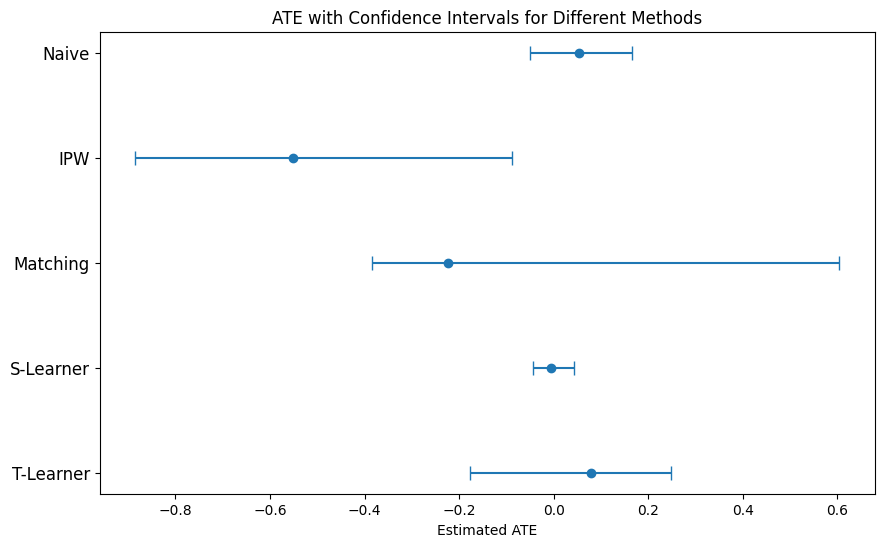

In [76]:
methods = results_df['Method']
ate_values = results_df['ATE']
lower_bounds = results_df['Lower Bound'] 
upper_bounds = results_df['Upper Bound'] 

errors = (upper_bounds - lower_bounds) / 2
means = (upper_bounds + lower_bounds) / 2

y_positions = range(len(methods), 0, -1)

# Plotting
plt.figure(figsize=(10, 6))
plt.errorbar(means, y_positions, xerr=errors, linestyle='None', capsize=5)
plt.scatter(ate_values, y_positions)

plt.yticks(y_positions, methods, fontsize=12)
plt.xlabel('Estimated ATE')
plt.title('ATE with Confidence Intervals for Different Methods')

plt.show()
